In [2]:
"""
GPU-Optimized Conditional DDPM for Fashion Product Images (T-shirts & Shirts)
Preloads all data to GPU to eliminate CPU bottlenecks.
"""

import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# ================================
# CONFIGURATION
# ================================
class Config:
    data_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset'
    image_size = 128
    batch_size = 64
    max_samples = 10000
    num_classes = 2
    time_emb_dim = 128
    base_channels = 64
    num_timesteps = 1000
    beta_start = 0.0001
    beta_end = 0.02
    num_epochs = 80
    learning_rate = 2e-4
    sample_interval = 2
    save_interval = 10

config = Config()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [4]:
# ================================
# DATASET
# ================================
class FashionDataset(Dataset):
    def __init__(self, csv_path, images_dir, target_categories, transform=None, max_samples=None):
        df = pd.read_csv(csv_path, on_bad_lines='skip')
        df = df[df['articleType'].isin(target_categories)].reset_index(drop=True)
        if max_samples and len(df) > max_samples:
            df = df.sample(n=max_samples, random_state=42).reset_index(drop=True)
        self.label_map = {cat: idx for idx, cat in enumerate(sorted(target_categories))}
        self.transform = transform
        self.images = []
        self.labels = []
        print("Loading images into memory...")
        for idx in tqdm(range(len(df))):
            img_id = str(df.iloc[idx]['id'])
            img_path = os.path.join(images_dir, f"{img_id}.jpg")
            if os.path.exists(img_path):
                img = Image.open(img_path).convert('RGB')
                if transform:
                    img = transform(img)
                self.images.append(img)
                self.labels.append(self.label_map[df.iloc[idx]['articleType']])
        self.images = torch.stack(self.images).to(device)
        self.labels = torch.tensor(self.labels, device=device)
        print(f"Loaded {len(self.images)} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# ================================
# TRANSFORMS & DATA
# ================================
transform = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

csv_path = os.path.join(config.data_path, 'styles.csv')
images_dir = os.path.join(config.data_path, 'images')
target_categories = ['Tshirts', 'Shirts']

dataset = FashionDataset(csv_path, images_dir, target_categories, transform, max_samples=config.max_samples)

Loading images into memory...


100%|██████████| 10000/10000 [12:11<00:00, 13.67it/s]


Loaded 9997 images


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from types import SimpleNamespace
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tqdm import tqdm


class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        device = t.device
        emb = torch.exp(torch.arange(half_dim, device=device) * -math.log(10000) / (half_dim - 1))
        emb = t[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

# ================================
# MODEL
# ================================
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(time_dim, out_ch)
        self.class_emb = nn.Embedding(num_classes, out_ch)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.shortcut = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb, class_label):
        h = self.conv1(F.relu(x))
        t_e = self.time_mlp(F.relu(t_emb))
        c_e = self.class_emb(class_label)
        h = h + t_e[:, :, None, None] + c_e[:, :, None, None]
        h = self.norm1(h)
        h = F.relu(h)
        h = self.conv2(h)
        h = self.norm2(h)
        return F.relu(h + self.shortcut(x))

class ConditionalUNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, time_dim=128, base_ch=64, num_classes=2):
        super().__init__()
        self.time_emb = TimeEmbedding(time_dim)
        # -----------------------
        # ENCODER
        # -----------------------
        self.enc1 = ResidualBlock(in_ch, base_ch, time_dim, num_classes)          # (128×128)
        self.enc2 = ResidualBlock(base_ch, base_ch*2, time_dim, num_classes)      # (64×64)
        self.enc3 = ResidualBlock(base_ch*2, base_ch*4, time_dim, num_classes)    # (32×32)
        self.enc4 = ResidualBlock(base_ch*4, base_ch*8, time_dim, num_classes)    # (16×16)
        self.pool = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = ResidualBlock(base_ch*8, base_ch*8, time_dim, num_classes)  # (8×8)
        
        # -----------------------
        # DECODER
        # -----------------------
        self.up4 = nn.ConvTranspose2d(base_ch*8, base_ch*8, 2, stride=2)  # 16
        self.dec4 = ResidualBlock(base_ch*8 + base_ch*8, base_ch*4, time_dim, num_classes)  # (512+512)=1024 → 256

        self.up3 = nn.ConvTranspose2d(base_ch*4, base_ch*4, 2, stride=2)  # 32
        self.dec3 = ResidualBlock(base_ch*4 + base_ch*4, base_ch*2, time_dim, num_classes)  # (256+256)=512 → 128

        self.up2 = nn.ConvTranspose2d(base_ch*2, base_ch*2, 2, stride=2)  # 64
        self.dec2 = ResidualBlock(base_ch*2 + base_ch*2, base_ch, time_dim, num_classes)    # (128+128)=256 → 64

        self.up1 = nn.ConvTranspose2d(base_ch, base_ch, 2, stride=2)      # 128
        self.dec1 = ResidualBlock(base_ch + base_ch, base_ch, time_dim, num_classes) # (64+64)=128 → 64

        self.final = nn.Conv2d(base_ch, out_ch, 1)

    def forward(self, x, t, class_label):
        t_emb = self.time_emb(t)

        # Encoder
        e1 = self.enc1(x, t_emb, class_label)              # 128
        e2 = self.enc2(self.pool(e1), t_emb, class_label)  # 64
        e3 = self.enc3(self.pool(e2), t_emb, class_label)  # 32
        e4 = self.enc4(self.pool(e3), t_emb, class_label)  # 16

        b = self.bottleneck(self.pool(e4), t_emb, class_label)  # 8

        # Decoder
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1), t_emb, class_label)  # 16
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1), t_emb, class_label) # 32
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1), t_emb, class_label) # 64
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1), t_emb, class_label) # 128

        return self.final(d1)

# ================================
# DDPM (GPU-SAFE)
# ================================
class ConditionalDDPM(nn.Module):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        device = next(model.parameters()).device

        betas = torch.linspace(config.beta_start, config.beta_end, config.num_timesteps, device=device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)

        # register buffers for GPU safety
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("alphas_cumprod_prev", alphas_cumprod_prev)
        self.register_buffer("sqrt_alphas_cumprod", sqrt_alphas_cumprod)
        self.register_buffer("sqrt_one_minus_alphas_cumprod", sqrt_one_minus_alphas_cumprod)

    def q_sample(self, x_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_0, device=x_0.device)
        t = t.to(self.sqrt_alphas_cumprod.device)
        sqrt_acp_t = self.sqrt_alphas_cumprod[t].view(-1,1,1,1)
        sqrt_om_acp_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1)
        return sqrt_acp_t * x_0 + sqrt_om_acp_t * noise

    def p_sample(self, x_t, t, class_label):
        t = t.to(x_t.device)
        predicted_noise = self.model(x_t, t, class_label)
        alpha_t = self.alphas[t].view(-1,1,1,1)
        alpha_cumprod_t = self.alphas_cumprod[t].view(-1,1,1,1)
        beta_t = self.betas[t].view(-1,1,1,1)
        mean = (x_t - beta_t / torch.sqrt(1 - alpha_cumprod_t) * predicted_noise) / torch.sqrt(alpha_t)
        mask = (t > 0).float().view(-1,1,1,1)
        noise = torch.randn_like(x_t)
        return mean + mask * torch.sqrt(beta_t) * noise

    @torch.no_grad()
    def sample(self, num_samples, class_labels):
        self.model.eval()
        x = torch.randn(num_samples, 3, self.config.image_size, self.config.image_size, device=next(self.model.parameters()).device)
        for i in reversed(range(self.config.num_timesteps)):
            t = torch.full((num_samples,), i, dtype=torch.long, device=x.device)
            x = self.p_sample(x, t, class_labels.to(x.device))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    data_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset'
    image_size = 128
    batch_size = 64
    max_samples = 10000
    num_classes = 2
    time_emb_dim = 128
    base_channels = 64
    num_timesteps = 1000
    beta_start = 0.0001
    beta_end = 0.02
    num_epochs = 20
    learning_rate = 2e-4
    sample_interval = 5
    save_interval = 10

config = Config()

model = ConditionalUNet(
    time_dim=config.time_emb_dim,
    base_ch=config.base_channels,
    num_classes=config.num_classes
).to(device)

ddpm = ConditionalDDPM(model, config).to(device)
ddpm.load_state_dict(torch.load("/kaggle/working/ddpm_fashion.pth", map_location=device))
ddpm.eval()

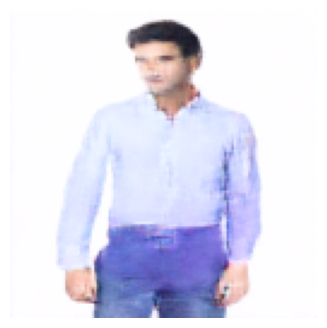

In [42]:
num_samples = 1
class_id = 0 # generate Tshirts

labels = torch.tensor([class_id] * num_samples, device=device)

with torch.no_grad():
    samples = ddpm.sample(num_samples, labels)   # shape: [N, 3, H, W]

def show_images(imgs):
    imgs = (imgs.clamp(-1, 1) + 1) / 2  # back to [0, 1]
    imgs = imgs.cpu().permute(0, 2, 3, 1).numpy()

    plt.figure(figsize=(12, 4))
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

show_images(samples)